In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, -1], dtype=complex)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    m, b = gs

    x, y = true

    return jnp.array([y, m * (1 - x**b) * y - x])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    m, b = cs

    x, y = nudged

    return jnp.array([y, m * (1 - x**b) * y - x])


# System evolution parameters
gs = m, b = 0.01, 2.15
gs = jnp.array(gs, dtype=complex)
c1, c2 = gs
c1 *= 1.2
c2 *= 0.8
cs = jnp.array([c1, c2], dtype=complex)

mu = 10
true0, assimilated0 = get_initial_values()
observed_mask = jnp.array([0, 1], dtype=bool)
system = System_ModelKnown(
    mu,
    gs,
    cs,
    observed_mask,
    assimilated_ode,
    true_ode,
    complex_differentiation=True,
)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 1600
t_relax = 0.8

gradient_computer = optim.gradient.AdjointGradient(
    system,
    dt,
    optim.gradient.adjoint.UpdateOption.complete,
    (ti.ForwardEuler, ti.TwoStepAdamsBashforth),
)
optimizer = optax.adam(1e-3)
optimizer = optim.OptaxWrapper(system, optimizer, gradient_computer)

true_solver = solver
trues, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = trues[:, system.observed_mask]

cs, u_errors, tls, assimilateds = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    return_all=True,
    t_begin_updates=50,
)
tls_all = np.arange(len(trues)) * dt

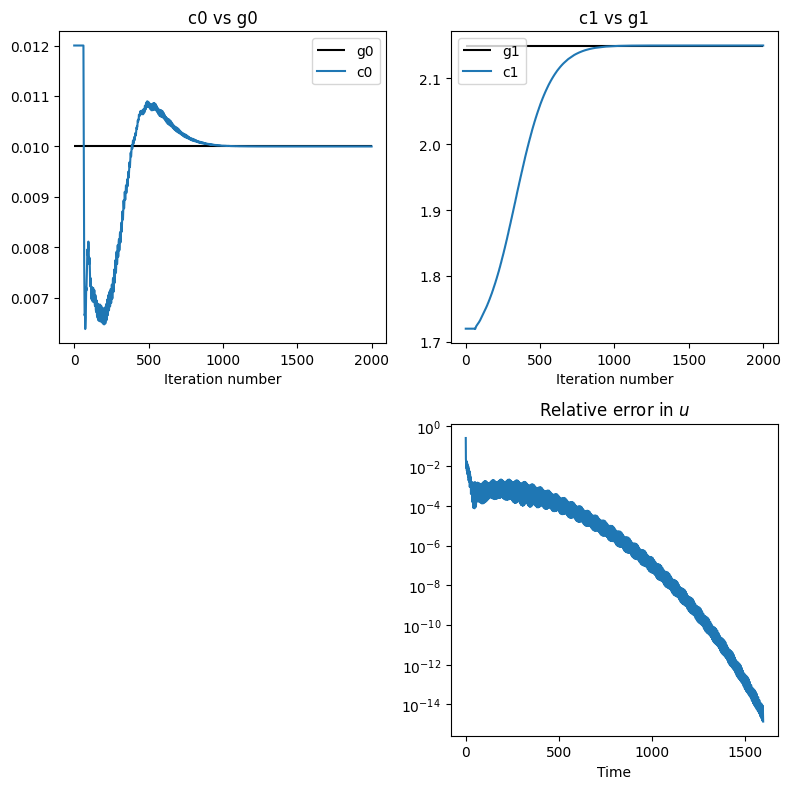

In [ ]:
fig, axs = plot(cs.real, u_errors, gs.real, tls)
fig.set_size_inches(8, 8)
fig.tight_layout()
plt.show()

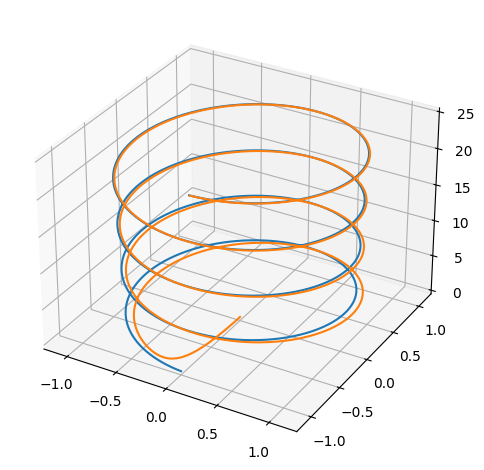

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})

s_ = np.s_[:2500]
ax.plot(*trues[s_].T.real, tls_all[s_])
ax.plot(*assimilateds[s_].T.real, tls_all[s_])

fig.tight_layout()
plt.show()